# Keras LSTM benchmark notebook

This notebook explores a different type of model architecture that will capture feature values at previous time steps

In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context('talk')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [139]:
#untie local dependency
import os
cwd = os.getcwd().split('\\')
local_repo_path = '\\'.join(cwd[:-1])
raw_data_path = local_repo_path + '\\data\\raw'
processed_data_path = local_repo_path + '\\data\\processed'
feature_path = local_repo_path + '\\data\\features'
submissions_path = local_repo_path + '\\submissions'

# Load data

In [140]:
output_feature_fname = '2degree_polys'
sj_feature_train = pd.read_csv(feature_path + r'\\sj_train_' + output_feature_fname + '.csv', index_col=0)
sj_feature_test = pd.read_csv(feature_path + r'\\sj_test_' + output_feature_fname + '.csv', index_col=0)
iq_feature_train = pd.read_csv(feature_path + r'\\iq_train_' + output_feature_fname + '.csv', index_col=0)
iq_feature_test = pd.read_csv(feature_path + r'\\iq_test_' + output_feature_fname + '.csv', index_col=0)

In [141]:
sj_feature_train.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,total_cases
0,0.0,-1.081814,-1.183554,-0.759571,-1.272727,-0.542448,-1.008038,-1.077631,-0.947159,-1.092417,...,-0.808394,-1.225806,-0.540115,-0.740437,-0.935945,-0.510820,-1.194577,-0.517934,-0.305917,4
1,0.0,-0.559956,-0.583693,-0.214395,-0.272727,-0.541333,-0.544774,-0.559237,-0.448256,-0.465126,...,-0.263413,-0.290432,-0.537789,-0.214041,-0.224612,-0.499007,-0.269139,-0.495076,-0.305623,5
2,0.0,0.006304,-0.005017,-0.214395,0.000000,-0.530953,0.006414,0.005247,-0.085027,-0.024420,...,-0.211121,-0.000225,-0.526301,-0.214041,-0.089200,-0.489124,0.000000,-0.479202,-0.302821,4
3,0.0,-0.061121,-0.053519,0.110260,0.227273,-0.510605,-0.061864,-0.061176,-0.011965,0.020094,...,0.079649,0.199738,-0.506222,0.111624,0.172680,-0.462490,0.229765,-0.454182,-0.296981,3
4,0.0,0.144991,0.146063,0.741194,0.500000,-0.479789,0.149107,0.144828,0.357315,0.254905,...,0.672788,0.461266,-0.475140,0.770548,0.609026,-0.416591,0.512061,-0.416642,-0.287263,6


In [142]:
sj_feature_test.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,city,year,weekofyear
0,0.0,-0.350555,-0.359024,-0.294028,-0.500000,-0.542448,-0.346830,-0.350584,-0.341174,-0.422406,...,-0.538431,-0.292531,-0.371501,-0.501638,-0.487939,-0.501071,-0.305917,sj,2008,18
1,0.0,-0.399342,-0.410314,-0.490046,-0.272727,-0.541333,-0.393565,-0.399213,-0.438764,-0.369601,...,-0.537433,-0.483404,-0.345179,-0.504469,-0.269139,-0.495076,-0.305623,sj,2008,19
2,0.0,-0.060573,-0.054077,0.306279,0.000000,-0.530953,-0.061312,-0.060687,0.058628,-0.065270,...,-0.526406,0.312657,0.144692,-0.478358,0.000000,-0.479202,-0.302821,sj,2008,20
3,0.0,-0.405372,-0.407526,0.361409,0.727273,-0.510605,-0.399315,-0.404767,-0.153909,-0.016402,...,-0.507042,0.369796,0.548707,-0.456872,0.752791,-0.441806,-0.296981,sj,2008,21
4,0.0,-0.266685,-0.268153,0.171516,0.227273,-0.479789,-0.265612,-0.266752,-0.126321,-0.108223,...,-0.476209,0.174090,0.200800,-0.430793,0.229765,-0.424166,-0.287263,sj,2008,22


## Fit and predict with Keras LSTM Neural Network

In [143]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from math import sqrt
from matplotlib import pyplot
from numpy import array
from sklearn.metrics import mean_absolute_error

In [144]:
def fit_and_predict_LSTM(train_wide, test_wide, epochs = 200, n_hidden = 25, activation = 'linear', verbose = 0):
    values = train_wide.values
    n_train = values.shape[0] - 100
    train = values[:n_train, :]
    val = values[n_train:, :]
    
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    val_X, val_y = val[:, :-1], val[:, -1]
    
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
    test_X = test_wide.drop(['city', 'year', 'weekofyear'], axis = 1).values
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    model = Sequential()
    model.add(LSTM(n_hidden, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(n_hidden))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    # fit network
    history = model.fit(train_X, train_y, epochs=epochs, batch_size=72, validation_data=(val_X, val_y), verbose=verbose, shuffle=False)
    
    plt.figure(figsize = (7,5))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.show()
    
    #build predictions for figure
    test_preds = model.predict(test_X)
    
    train_X_full = values[:,:-1]
    train_preds = model.predict(train_X_full.reshape((train_X_full.shape[0], 1, train_X_full.shape[1])))
    
    fig, ax = plt.subplots(figsize = (20,10))
    train_error = np.round(mean_absolute_error(train_preds, train_wide['total_cases']),1)
    pd.DataFrame(train_preds).plot(ax = ax)
    pd.DataFrame(train_wide['total_cases']).reset_index(drop = True).plot(ax = ax)
    pd.DataFrame(test_preds).set_index(np.arange(len(train_wide), len(train_wide)+ len(test_preds))).plot(ax = ax)
    
    ax.legend(labels = ['Predicted', 'True', 'Fitted'])
    ax.set_title('Mean train error: ' + str(train_error))
    return(model, train_preds, test_preds)

In [145]:
sj_feature_train['total_cases'] = np.log(1 + sj_feature_train['total_cases'])

In [ ]:
sj_model, sj_train_preds, sj_test_preds = fit_and_predict_LSTM(sj_feature_train, sj_feature_test, epochs = 10000, n_hidden = 40, verbose = 2)

Train on 836 samples, validate on 100 samples
Epoch 1/10000
 - 4s - loss: 2.9715 - val_loss: 2.5757
Epoch 2/10000
 - 0s - loss: 2.6947 - val_loss: 2.2881
Epoch 3/10000
 - 0s - loss: 2.3262 - val_loss: 1.9382
Epoch 4/10000
 - 0s - loss: 1.8800 - val_loss: 1.5416
Epoch 5/10000
 - 0s - loss: 1.4354 - val_loss: 1.1415
Epoch 6/10000
 - 0s - loss: 1.1960 - val_loss: 1.0373
Epoch 7/10000
 - 0s - loss: 1.0938 - val_loss: 0.9556
Epoch 8/10000
 - 0s - loss: 1.0090 - val_loss: 0.8915
Epoch 9/10000
 - 0s - loss: 0.9417 - val_loss: 0.7981
Epoch 10/10000
 - 0s - loss: 0.8966 - val_loss: 0.7442
Epoch 11/10000
 - 0s - loss: 0.8487 - val_loss: 0.6998
Epoch 12/10000
 - 0s - loss: 0.8119 - val_loss: 0.6798
Epoch 13/10000
 - 0s - loss: 0.7703 - val_loss: 0.6559
Epoch 14/10000
 - 0s - loss: 0.7553 - val_loss: 0.6588
Epoch 15/10000
 - 0s - loss: 0.7368 - val_loss: 0.6702
Epoch 16/10000
 - 0s - loss: 0.7305 - val_loss: 0.6336
Epoch 17/10000
 - 0s - loss: 0.7449 - val_loss: 0.6690
Epoch 18/10000
 - 0s - loss:

In [137]:
iq_feature_train['total_cases'] = np.log(1 + iq_feature_train['total_cases'])

Train on 420 samples, validate on 100 samples
Epoch 1/500
 - 4s - loss: 1.5761 - val_loss: 1.8191
Epoch 2/500
 - 0s - loss: 1.4219 - val_loss: 1.7209
Epoch 3/500
 - 0s - loss: 1.2977 - val_loss: 1.6156
Epoch 4/500
 - 0s - loss: 1.2033 - val_loss: 1.4964
Epoch 5/500
 - 0s - loss: 1.1136 - val_loss: 1.3839
Epoch 6/500
 - 0s - loss: 1.0508 - val_loss: 1.2999
Epoch 7/500
 - 0s - loss: 1.0267 - val_loss: 1.2388
Epoch 8/500
 - 0s - loss: 1.0084 - val_loss: 1.2018
Epoch 9/500
 - 0s - loss: 0.9870 - val_loss: 1.1762
Epoch 10/500
 - 0s - loss: 0.9789 - val_loss: 1.1564
Epoch 11/500
 - 0s - loss: 0.9559 - val_loss: 1.1386
Epoch 12/500
 - 0s - loss: 0.9552 - val_loss: 1.1238
Epoch 13/500
 - 0s - loss: 0.9298 - val_loss: 1.1086
Epoch 14/500
 - 0s - loss: 0.9261 - val_loss: 1.0925
Epoch 15/500
 - 0s - loss: 0.9045 - val_loss: 1.0750
Epoch 16/500
 - 0s - loss: 0.9008 - val_loss: 1.0606
Epoch 17/500
 - 0s - loss: 0.8998 - val_loss: 1.0449
Epoch 18/500
 - 0s - loss: 0.8954 - val_loss: 1.0285
Epoch 19/

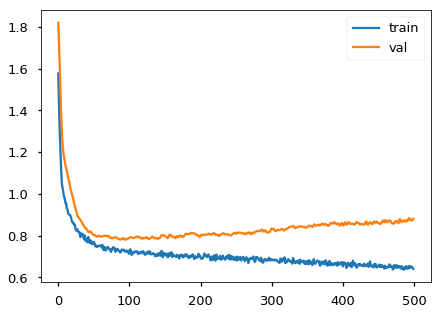

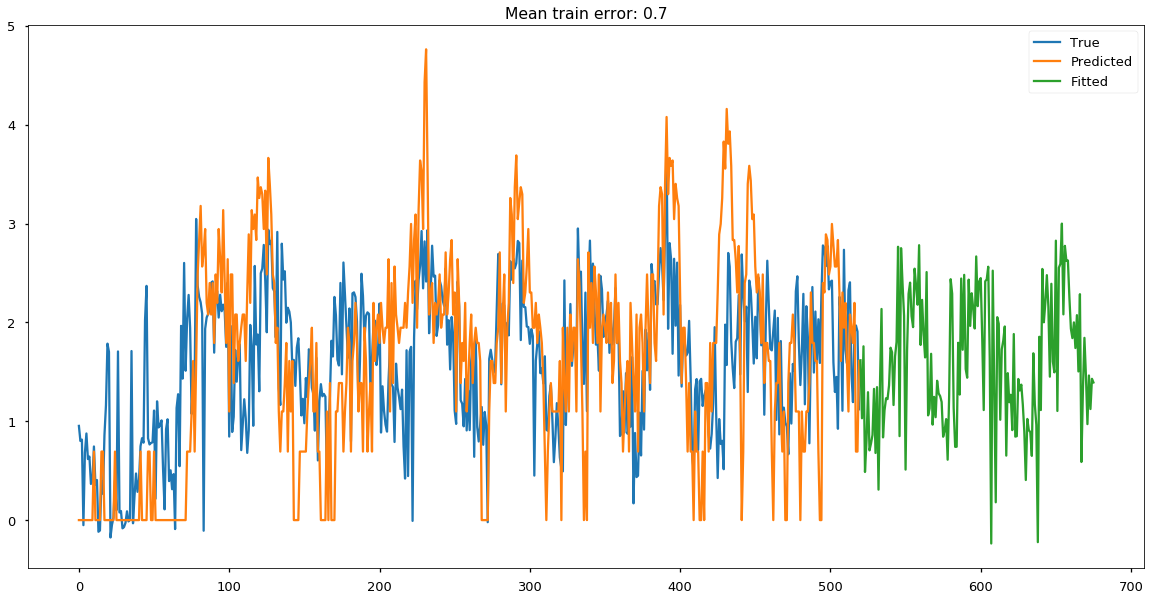

In [111]:
iq_model, iq_train_preds, iq_test_preds = fit_and_predict_LSTM(iq_feature_train, iq_feature_test, epochs = 500, n_hidden = 20, verbose = 2)

# Create submission

In [122]:
sj_sub = pd.DataFrame((np.expm1(sj_test_preds)).astype(int), columns = ['total_cases'])
sj_sub['year'] = sj_feature_test['year']
sj_sub['weekofyear'] = sj_feature_test['weekofyear']
sj_sub['city'] = 'sj'

In [123]:
iq_sub = pd.DataFrame(np.expm1(iq_test_preds).astype(int), columns = ['total_cases'])
iq_sub['year'] = iq_feature_test['year']
iq_sub['weekofyear'] = iq_feature_test['weekofyear']
iq_sub['city'] = 'iq'

In [124]:
sub = sj_sub.append(iq_sub)[['city', 'year', 'weekofyear', 'total_cases']]

In [125]:
sub.loc[sub['total_cases'] < 0, 'total_cases'] = 0

In [126]:
sub

,city,year,weekofyear,total_cases
0,sj,2008,18,6
1,sj,2008,19,5
2,sj,2008,20,8
3,sj,2008,21,9
4,sj,2008,22,7
5,sj,2008,23,10
6,sj,2008,24,8
7,sj,2008,25,12
8,sj,2008,26,13
9,sj,2008,27,17


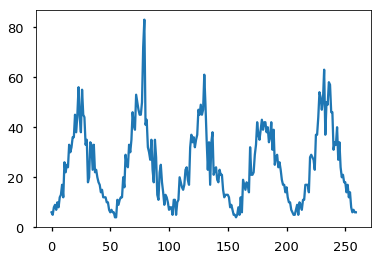

In [128]:
sub[sub['city'] == 'sj']['total_cases'].plot()

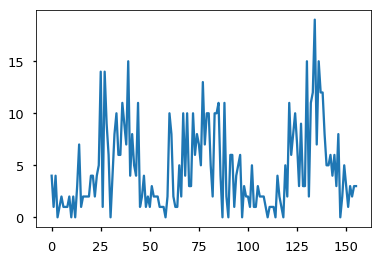

In [129]:
sub[sub['city'] == 'iq']['total_cases'].plot()

In [118]:
sub.to_csv(submissions_path + '/Keras_LSTM_'+ output_feature_fname + '.csv', index = False)